<a href="https://colab.research.google.com/github/GaoangLiu/AA_ipynb/blob/master/Disaster_Tweets_with_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Logistic Regression to classify tweets on disaster are real or not. 

CNN way can be found [here](https://github.com/GaoangLiu/AA_ipynb/blob/master/NLP_with_Disaster_Tweets.ipynb)

Naive Bayes can be found [here](https://github.com/GaoangLiu/AA_ipynb/blob/master/NLP_with_Disaster_Tweets.ipynb)


In [0]:
# Load packages 
import math
import re
import os
import timeit
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import logging
import time
import smart_open
import importlib

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
logging.basicConfig(format='[%(asctime)s %(levelname)8s] %(message)s', level=logging.INFO, datefmt='%m-%d %H:%M:%S')

from keras import layers, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Flatten, Dense, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

import B7 # boost117


In [267]:
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

Download data

In [268]:
! rm *.csv *.zip
! wget -O tweets.zip ali.140714.xyz:8000/nlp-getting-started.zip 
! unzip tweets.zip 
! ls
! wget -O labels.csv ali.140714.xyz:8000/leaked_tweet_labels.csv

--2020-05-14 12:36:30--  http://ali.140714.xyz:8000/nlp-getting-started.zip
Resolving ali.140714.xyz (ali.140714.xyz)... 47.240.16.188
Connecting to ali.140714.xyz (ali.140714.xyz)|47.240.16.188|:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘tweets.zip’

tweets.zip          100%[===================>] 593.11K  --.-KB/s    in 0.07s   

2020-05-14 12:36:31 (8.50 MB/s) - ‘tweets.zip’ saved [607343/607343]

Archive:  tweets.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
B7.py  gggbost.py    sample_data	    train.csv	Z.py
B8.py  iiiextern.py  sample_submission.csv  tweets.zip
C.py   __pycache__   test.csv		    X.py
--2020-05-14 12:36:37--  http://ali.140714.xyz:8000/leaked_tweet_labels.csv
Resolving ali.140714.xyz (ali.140714.xyz)... 47.240.16.188
Connecting to ali.140714.xyz (ali.140714.xyz)|47.240.16.188|:8000... connected.
HTTP request sent, awaiti

In [269]:
df = pd.read_csv('train.csv')
results = set()
s = df.text.str.lower().str.split(' ').apply(results.update)
s, len(s)

(0       None
 1       None
 2       None
 3       None
 4       None
         ... 
 7608    None
 7609    None
 7610    None
 7611    None
 7612    None
 Name: text, Length: 7613, dtype: object, 7613)

Naive Bayes model

In [0]:
class Classifier():
  def __init__(self):
    self.train = None
    self.test = None 
    self.model = None
    
  def load_data(self, train_file='train.csv', test_file='test.csv'):
      """ Load train, test csv files and return pandas.DataFrame
      """
      self.train = pd.read_csv(train_file, engine='python', encoding='utf-8', error_bad_lines=False)
      self.test = pd.read_csv(test_file, engine='python', encoding='utf-8', error_bad_lines=False)
      logging.info('CSV data loaded')
  
  def countvectorize(self):
      tv = TfidfVectorizer(ngram_range=(1,5), token_pattern=r'\w{1,}',
               min_df=3, max_df=0.9, strip_accents='unicode', 
               sublinear_tf=1, max_features=5000)
    #   tv = CountVectorizer()
      tv.fit(self.train.text)
      self.vector_train = tv.transform(self.train.text)
      self.vector_test  = tv.transform(self.test.text)
      logging.info("Train & test text tokenized")

  def train_model(self):
      # Choose your own classifier: self.model and run it
      logging.info(f"{self.__class__.__name__} starts running.")
      labels = self.train.target
      X_train, X_val, y_train, y_val = train_test_split(self.vector_train, labels, test_size=0.1, random_state=2020)
      self.model.fit(X_train, y_train)
      
      self.X_val, self.y_val = X_val, y_val 
      return self.model
    #   y_preds = self.model.predict(x_val)

    #   logging.info(f"Accuracy score: {accuracy_score(y_val, y_preds)}")
    #   logging.info(f"Confusion matrix: ") 
    #   print(confusion_matrix(y_val, y_preds))
    #   print("Classificaiton report:\n", classification_report(y_val, y_preds, target_names=["real", "unreal"]))
    #   y_preds = self.model.predict(self.vector_test)
    #   return y_preds

  def save_predictions(self, y_preds):
      sub = pd.read_csv(f"sample_submission.csv")
      sub['target'] = y_preds 
      sub.to_csv(f"submission_{self.__class__.__name__}.csv", index=False)
      logging.info(f'Prediction exported to submission_{self.__class__.__name__}.csv')
  
  def pipeline(self):
      s_time = time.clock()
      self.load_data()
      self.countvectorize()
      self.build_model()
      self.train_model()
      logging.info(f"Program running for {time.clock() - s_time} seconds")

class C_SVM(Classifier):
  def build_model(self):
      self.model = svm.SVC(probability=True)
      return self.model

def super_blender():
    blended = np.zeros(3263)
    for _ in range(3):
        nb = C_Bayes()
        nb.pipeline()

        importlib.reload(B7)
        y_preds = nb.model.predict_proba(nb.X_val)
        y_preds = y_preds[:, 1] # keep only the second column
        threshold = B7.Search().find_best_threshold(y_preds, nb.y_val)
        
        test_preds = nb.model.predict_proba(nb.vector_test)
        blended += (test_preds[:, 1] >= threshold).astype(int)
    return blended


In [277]:
# %reset 
c = C_SVM()
c.pipeline()
labels = pd.read_csv('labels.csv').target
# preds = pd.read_csv('submission_C_Bayes.csv').target
# print("The submission f1_score is: ", f1_score(labels, preds, average='weighted'))

[05-14 12:41:03     INFO] CSV data loaded
[05-14 12:41:05     INFO] Train & test text tokenized
[05-14 12:41:05     INFO] C_SVM starts running.
[05-14 12:41:46     INFO] Program running for 42.785009 seconds


Best f1 score 0.7952755767278785, best threshold 0.47000000000000025


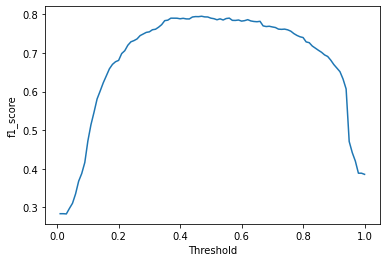

In [278]:
# B7.Files().download_vps('boost117.py', new_name='B7.py')
importlib.reload(B7)

y_preds = c.model.predict_proba(c.X_val)
y_preds = y_preds[:, 1] # keep only the second column
threshold = B7.Search().find_best_threshold(y_preds, c.y_val)

In [279]:
test_preds = c.model.predict_proba(c.vector_test)
test_preds = (test_preds[:, 1] >= threshold).astype(int)
c.save_predictions(test_preds)
print("f1_score is", f1_score(pd.read_csv('labels.csv').target, test_preds, average='weighted'))
B7.Files().upload_vps('submission_C_SVM.csv')
# !ls

[05-14 12:42:01     INFO] Prediction exported to submission_C_SVM.csv


f1_score is 0.7964321375635016


[05-14 12:42:02     INFO] submission_C_SVM.csv was uploaded
